In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gplately
from gplately import pygplates
import pandas as pd
from scipy import ndimage
from scipy.spatial import cKDTree
from matplotlib.lines import Line2D
from skimage import feature

# agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
# agegrid_filename = agegrid_dir+"SampleData/1Ga_model/v2/AgeGrids_0.5d/masked/seafloor_age_mask_{:.1f}Ma.nc"

# reconstruction_times = np.arange(0,1001)

# Call GPlately's DataServer from the download.py module
# gdownload = gplately.download.DataServer("Merdith2021")

agegrid_dir = "/Users/ben/Dropbox/USyd/GPlates/"
agegrid_filename = agegrid_dir+"slab_dip/Clennet_AgeGrids_0.1d_masked/seafloor_age_mask_{:.1f}Ma.nc"
LIP_filename = "/Users/ben/Dropbox/USyd/GPlates/SampleData/FeatureCollections/LargeIgneousProvinces_VolcanicProvinces/Johansson_etal_2018_VolcanicProvinces/Johansson_etal_2018_VolcanicProvinces_v2.gpmlz"

reconstruction_times = np.arange(0,171)

In [8]:
# Call GPlately's DataServer from the download.py module
gdownload = gplately.download.DataServer("Clennett2020")

# Obtain all rotation files, topology features and static polygons from Muller et al. 2019
rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

# Obtain geometry shapefiles with gdownload
coastlines, continents, COBs = gdownload.get_topology_geometries()
gplot = gplately.plot.PlotTopologies(model, coastlines, continents, COBs)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!


## Load commodities

In [11]:
metal_dict = dict()

commodities = ['Cu (Mt)', 'Pb (Mt)', 'Zn (Mt)', 'Ni (Mt)']
sheets = ['PbZn-CD', 'PbZn-MVT', 'Cu-sed', 'Magmatic Ni', 'VMS', 'Cu-por', 'IOCG']

for sheet in sheets:
    df = pd.read_excel('data/base_metal_deposit_compilation.xls', sheet_name=sheet, na_values='ND')
    df = df[df['Age (Ga)'].notna()]
    df = df[df['Age (Ga)']*1000 <= reconstruction_times.max()]

    if df.shape[0] > 0:
        metal_dict[sheet] = df
    else:
        sheets.remove(sheet)
        
symbols = ['o', 'v', 's', '*', 'd', '^', 'P']*2

In [12]:
pts_dict = dict()

for i, sheet in enumerate(sheets):
    df = metal_dict[sheet]

    pts_dict[sheet] = gplately.Points(model, df['Lon'], df['Lat'])

## Load seamounts and LIPs

In [13]:
seamounts_filename = "data/Pacific_synthetic_seamounts.gpml"
seamounts = pygplates.FeatureCollection(seamounts_filename)

LIP_conjugates_filename = "data/LIP_conjugates/LIP_conjugates_0Ma.shp"
LIPs_filename = "data/Whittaker_etal_2015_LIPs.gpmlz"
LIPs = pygplates.FeatureCollection(LIP_conjugates_filename)
LIPs.add(pygplates.FeatureCollection(LIPs_filename))

# These don't work because the hotspot reference frame is not included in Clennett 2020
hotspots_filename = "data/Hotspots_Compilation_Whittaker_etal.gpmlz"
hotspots = pygplates.FeatureCollection(hotspots_filename)

In [14]:
def grad(raster, tol_grad=2, iter_dilation=0, mask=True, return_gradient=False):
    image = raster.fill_NaNs(return_array=True)
    gradX, gradY = np.gradient(image)
    gradXY = np.hypot(gradX, gradY)
    
    mask_fz = gradXY > tol_grad

    fz_grid = np.zeros(mask_fz.shape)
    fz_grid[mask_fz] = 1

    if iter_dilation:
        fz_grid = ndimage.binary_dilation(fz_grid, iterations=iter_dilation)
    
    if mask:
        fz_grid[raster.data.mask] = np.nan
        
    fz_raster = gplately.Raster(data=fz_grid, extent='global')    
    
    if return_gradient:
        return fz_raster, gradXY
    else:
        return fz_raster


def reconstruct_fracture_zones(time, return_grid=False, subduction_data=None):
    if subduction_data is None:
        subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.2), ignore_warnings=True)
    subduction_data = subduction_data.copy()
    trench_lons = subduction_data[:,0]
    trench_lats = subduction_data[:,1]
    trench_norm = subduction_data[:,7]

    # store these for later
    subduction_lons = trench_lons.copy()
    subduction_lats = trench_lats.copy()
    
    dlon = -2.5*np.sin(np.radians(trench_norm))
    dlat = -2.5*np.cos(np.radians(trench_norm))
    
    trench_lons += dlon
    trench_lats += dlat
    
    agegrid_raster = gplately.Raster(filename=agegrid_filename.format(time))
    fz_raster, gradXY = grad(agegrid_raster, tol_grad=2, iter_dilation=0, mask=False, return_gradient=True)
    mask_raster = fz_raster.data >= 1
    fz_raster.data[mask_raster] = gradXY[mask_raster]
    
    trench_fz = fz_raster.interpolate(trench_lons, trench_lats, method='nearest')
    
    # mask points where fracture zone intersects a subduction zone
    mask_trench_fz = trench_fz > 0
    trench_fz   = trench_fz[mask_trench_fz]
    trench_lons = subduction_lons[mask_trench_fz]
    trench_lats = subduction_lats[mask_trench_fz]
    
    if return_grid:
        return trench_lons, trench_lats, trench_fz, fz_raster.data
    else:
        return trench_lons, trench_lats, trench_fz

def reconstruct_seamount_subduction(time, dtol=50, return_seamounts=False, subduction_data=None):
    if subduction_data is None:
        subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.2), ignore_warnings=True)
    trench_lons = subduction_data[:,0]
    trench_lats = subduction_data[:,1]
    trench_norm = subduction_data[:,7]
    
    # reconstruct seamount and extract points on sphere
    reconstructed_seamounts = model.reconstruct(seamounts_filename, time)
    seamount_lons = np.zeros(len(reconstructed_seamounts))
    seamount_lats = np.zeros(len(reconstructed_seamounts))
    for i, seamount in enumerate(reconstructed_seamounts):
        seamount_lats[i], seamount_lons[i] = seamount.get_reconstructed_geometry().to_lat_lon()
    
    # find the nearest trench segment for each seamount
    xt, yt, zt = gplately.tools.lonlat2xyz(trench_lons, trench_lats)
    xs, ys, zs = gplately.tools.lonlat2xyz(seamount_lons, seamount_lats)
    tree_seamount = cKDTree(np.c_[xs,ys,zs])
    dist_to_seamount, idx_seamount = tree_seamount.query(np.c_[xt, yt, zt])
    dist_to_seamount *= gplately.EARTH_RADIUS
    
    # filter trench segments within dtol of each seamount
    mask_trench_seamount = dist_to_seamount <= dtol
    sz_lons = trench_lons[mask_trench_seamount]
    sz_lats = trench_lats[mask_trench_seamount]
    
    if return_seamounts:
        return seamount_lons, seamount_lats, sz_lons, sz_lats
    else:
        return sz_lons, sz_lats


def reconstruct_LIP_subduction(time, dtol=50, return_LIPs=False, subduction_data=None):
    if subduction_data is None:
        subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.2), ignore_warnings=True)
    trench_lons = subduction_data[:,0]
    trench_lats = subduction_data[:,1]
    
    # reconstruct seamount and extract points on sphere
    LIPs = pygplates.FeatureCollection(LIP_conjugates_filename)
    LIPs.add(pygplates.FeatureCollection(LIPs_filename))
    reconstructed_LIPs = model.reconstruct(LIPs, time)
    

    # find the nearest trench segment for each LIP
    xt, yt, zt = gplately.tools.lonlat2xyz(trench_lons, trench_lats)
    tree_trench = cKDTree(np.c_[xt,yt,zt])
    
    trench_LIP_lons = []
    trench_LIP_lats = []
    
    for LIP in reconstructed_LIPs:
        LIP_coords = LIP.get_reconstructed_geometry().get_points().to_lat_lon_array()
        LIP_lons = LIP_coords[:,1]
        LIP_lats = LIP_coords[:,0]
        xl, yl, zl = gplately.tools.lonlat2xyz(LIP_lons, LIP_lats)
        
        dist_to_LIP, idx_LIP = tree_trench.query(np.c_[xl, yl, zl])
        dist_to_LIP *= gplately.EARTH_RADIUS
        mask_trench_LIP = dist_to_LIP <= dtol

        trench_LIP_lons.extend(trench_lons[idx_LIP[mask_trench_LIP]])
        trench_LIP_lats.extend(trench_lats[idx_LIP[mask_trench_LIP]])
    
    if return_LIPs:
        return reconstructed_LIPs, np.array(trench_LIP_lons), np.array(trench_LIP_lats)
    else:
        return np.array(trench_LIP_lons), np.array(trench_LIP_lats)

In [46]:
def plot_timeseries(time, projection=ccrs.Mollweide(180), extent='global'):
    subduction_data = model.tessellate_subduction_zones(time, np.deg2rad(0.2), ignore_warnings=True)

    # fracture zones
    sm_lons, sm_lats, sz_lons, sz_lats  = reconstruct_seamount_subduction(time, return_seamounts=True, subduction_data=subduction_data)
    LIP_features, LIP_lons, LIP_lats    = reconstruct_LIP_subduction(time, return_LIPs=True, subduction_data=subduction_data)
    fz_lons, fz_lats, fz_mag, fz_raster = reconstruct_fracture_zones(time, return_grid=True, subduction_data=subduction_data)

    LIP_ft = model.reconstruct(pygplates.FeatureCollection(LIPs_filename), time)
    LIP_conj_ft = model.reconstruct(pygplates.FeatureCollection(LIP_conjugates_filename), time)

    
    # set up map plot
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111, projection=projection)
    if extent == "global":
        ax.set_global()
    else:
        ax.set_extent(extent)
    ax.gridlines(color='0.7', linestyle=':', xlocs=np.arange(-180,180,30), ylocs=np.arange(-90,90,30))


    # Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
    gplot.time = time # Ma
    # gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
    gplot.plot_grid(ax, fz_raster, origin='lower', cmap='RdPu', vmin=0, vmax=2)
    gplot.plot_all_topologies(ax, color='k')
    gplot.plot_continents(ax, color='0.85')
    gplot.plot_coastlines(ax, color='0.6')
    # gplot.plot_ridges_and_transforms(ax, color='red', zorder=9)

    # # reconstruct hotspots and extract points on sphere
    # reconstructed_hotspots = model.reconstruct(hotspots_filename, time)
    # hotspot_lons = np.zeros(len(reconstructed_hotspots))
    # hotspot_lats = np.zeros(len(reconstructed_hotspots))
    # for i, hotspot in enumerate(reconstructed_hotspots):
    #     hotspot_lats[i], hotspot_lons[i] = hotspot.get_reconstructed_geometry().to_lat_lon()
        
    # ax.scatter(hotspot_lons, hotspot_lats, marker='*', color='cyan', edgecolor='DarkBlue', linewidth=0.5,
    #            transform=gplot.base_projection)

    if len(LIP_ft):
        gplot.plot_feature(ax, LIP_ft, color='Maroon', )
    if len(LIP_conj_ft):
        gplot.plot_feature(ax, LIP_conj_ft, color='Maroon', )
    if len(sm_lons):
        ax.scatter(sm_lons, sm_lats, c='DarkBlue', marker='.', s=3, transform=gplot.base_projection)
    
    ax.scatter(fz_lons, fz_lats,   c='yellow', transform=gplot.base_projection)
    ax.scatter(LIP_lons, LIP_lats, c='magenta', transform=gplot.base_projection)
    ax.scatter(sz_lons, sz_lats,   c='cyan', transform=gplot.base_projection)

    gplot.plot_trenches(ax, color='k', zorder=9)
    gplot.plot_subduction_teeth(ax, color='k', zorder=10)

    colours = ['C0', 'C3', 'C2', 'C4', 'C5', 'orange']
    
    # plot metals
    legend_elements = []
    for i, sheet in enumerate(sheets):
        gpts = pts_dict[sheet]
        df = metal_dict[sheet]
        
        ages = df['Age (Ga)']*1000
        mask_ages = ages >= time
        
        # create label for each sheet and add commodities
        label = ""
        size  = np.zeros(df.shape[0])
        for commodity in commodities:
            if commodity in df:
                label += "{} + ".format(commodity[:-5])
                size  += df[commodity].fillna(0.0).to_numpy()
        label = label[:-3] + " ({})".format(sheet)
        
        if mask_ages.any():
            # reconstruct
            rlons, rlats = gpts.reconstruct(time, return_array=True)

            sc = ax.scatter(rlons[mask_ages], rlats[mask_ages],
                            s=10+size[mask_ages]*2, 
                            marker=symbols[i],
                            color=colours[i],
                            label=label, transform=gplot.base_projection,
                            edgecolor='k', linewidth=0.5, zorder=11)
            
        # create legend elements
        legend_elements.append( Line2D([0],[0], color=colours[i], marker=symbols[i], label=label,
                                       linestyle='none', markeredgecolor='k', markeredgewidth=0.5) )
    
    fig.legend(handles=legend_elements, loc='center', frameon=False, bbox_to_anchor=(0.5,0), ncol=2,
               title='Mineral deposit types', title_fontsize=12)


    fig.text(0.17, 0.8, "{:4d} Ma".format(time), fontsize=12)
    
    fig.savefig("figures/fz_metals_{:04d}Ma.pdf".format(time), dpi=300, bbox_inches='tight')
    fig.savefig("figures/fz_metals_{:04d}Ma.png".format(time), dpi=300, bbox_inches='tight')
    # plt.close(fig)

### Key timesteps

#### Northeast Asia

- 11 Ma - VMS deposits in northeast Asia

#### South America

- 5 Ma subduction of seamount in Argentina
- 38 - 28 Ma subduction of Manihiki LIP near Peru

#### North America
- 60 Ma fracture zone subduction near San Francisco (end of Shatsky Rise and Hess subduction)
- 65 Beginning of Hess subduction
- 83 Ma good timestep showing Hess and Shatksy subduction
- 88 Ma beginning of Shatsky Rise subduction


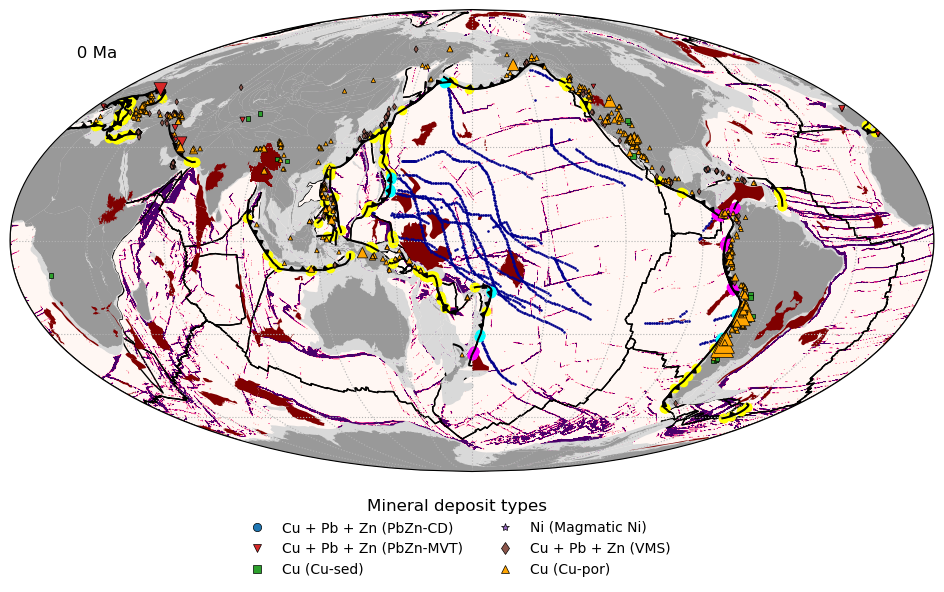

In [20]:
model.anchor_plate_id = 0
gplot.anchor_plate_id = 0

plot_timeseries(0)

In [30]:
model.anchor_plate_id = 0
gplot.anchor_plate_id = 0

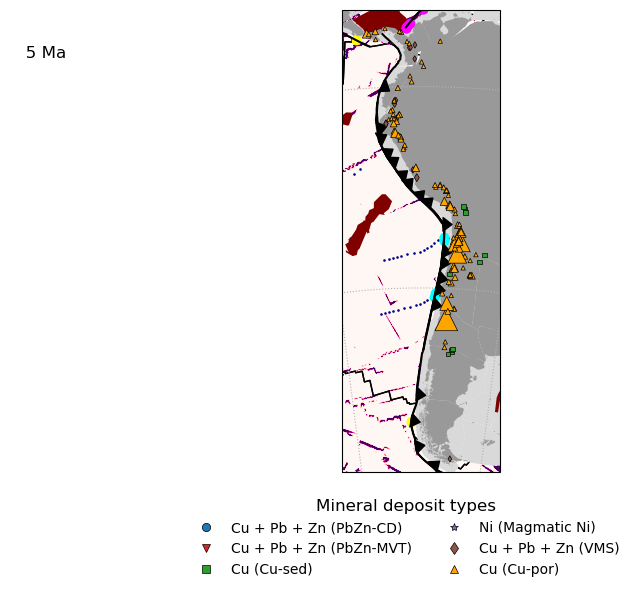

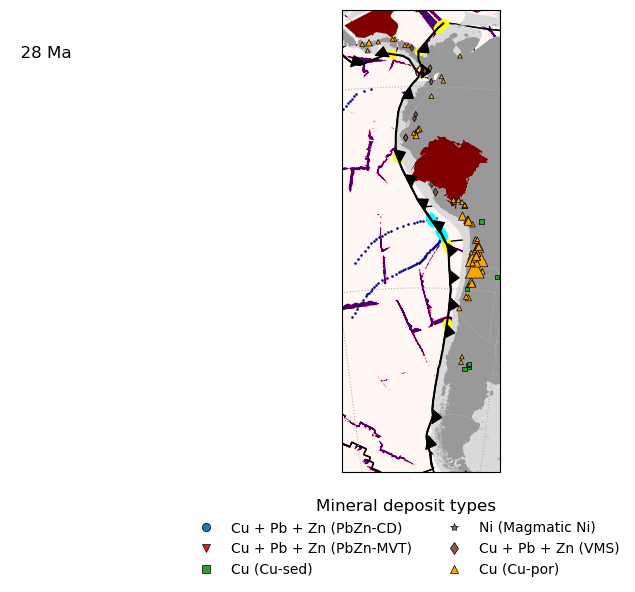

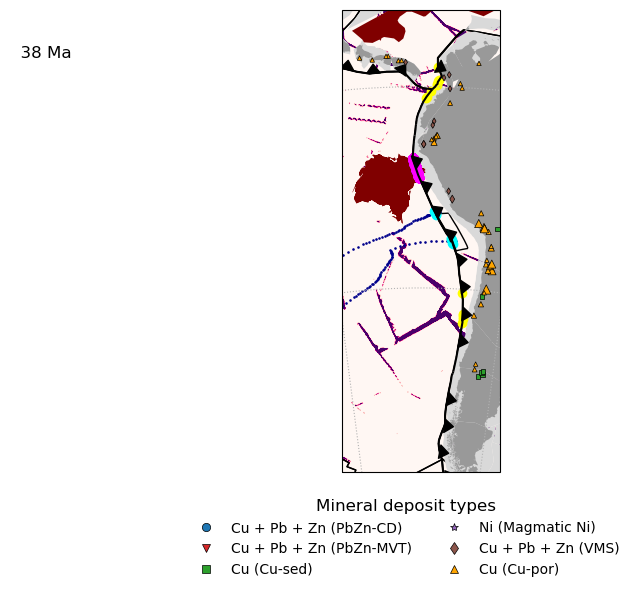

In [31]:
# South America
for time in [5, 28, 38]:
    plot_timeseries(time, ccrs.EquidistantConic(-75, -20, standard_parallels=(-10,-50)), [-85,-65,-57,12])

In [42]:
model.anchor_plate_id = 0
gplot.anchor_plate_id = 0

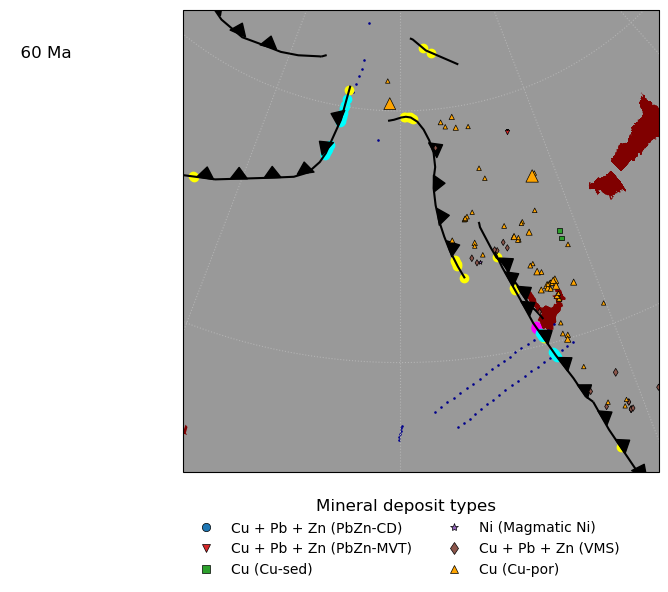

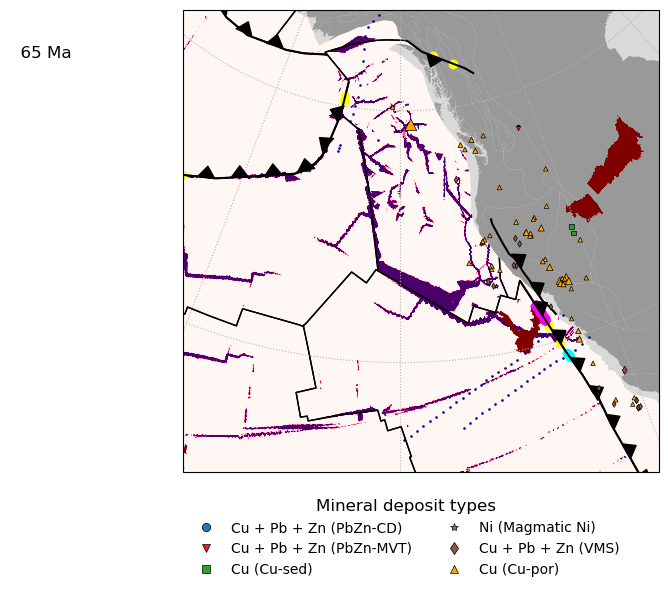

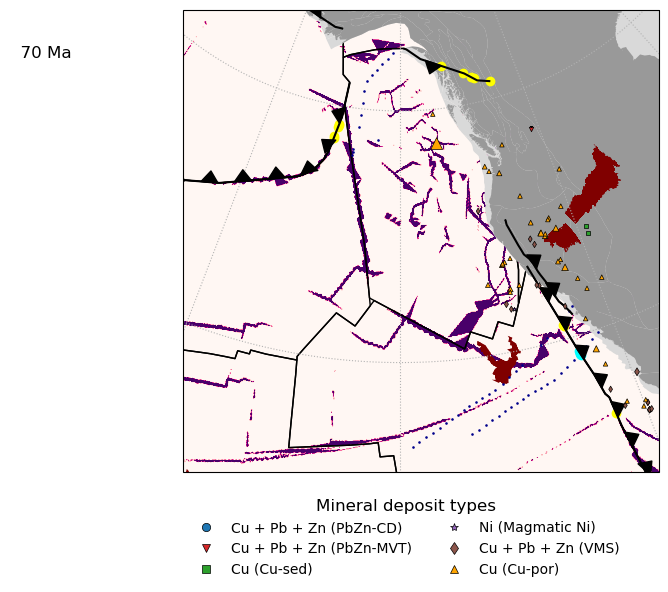

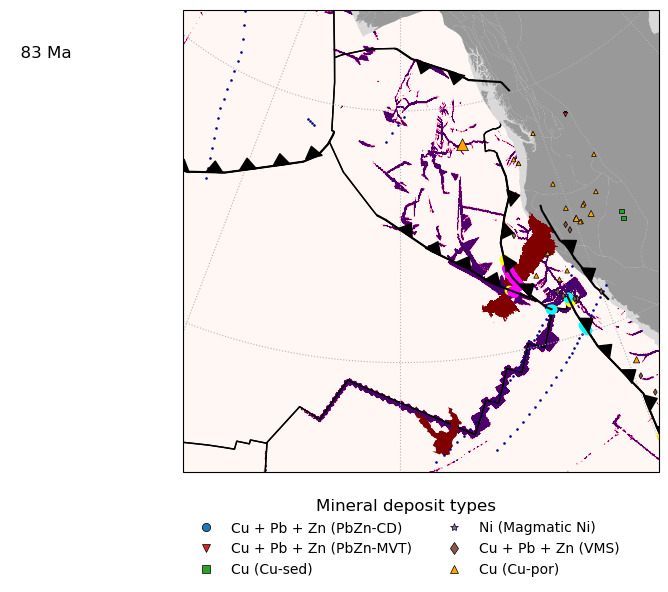

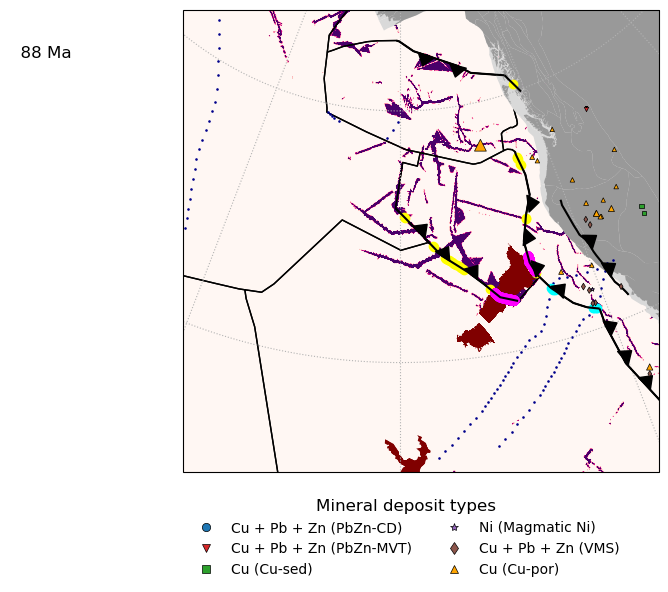

In [47]:
for time in [60, 65, 70, 83, 88]:
    plot_timeseries(time, ccrs.EquidistantConic(-120, 45, standard_parallels=(30,60)), [-145, -90, 15, 70])
    